<a href="https://colab.research.google.com/github/aayomide/Market-Analytics/blob/main/Analyzing_Market_Campaign_Data_With_Pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyzing Market Campaign Data With Pandas
In this mini-project, I will be assuming a role as data scientist on a marketing team of a fictitious company, Eltee Co. I will be analyzing market campaign data of Eltee Co.

Defining and understanding the marketing metrics 
`Conversion rate` and `Retention rate` are the two metrics we'll use to measure the campaign performance.
> - Conversion Rate is `number of people that converted(subscribed) / total number people marketed to`
> - Retention Rate is `number of people who remain subsribed / total number of intial subscribers`

## Import Libraries and Load Data

In [ ]:
# Import plotting libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.options.display.max_columns = 22

In [ ]:
# load the campaign data
marketing = pd.read_csv('marketing.csv', parse_dates=['date_served', 'date_subscribed'])

# preview first few rows
marketing.head()

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
0,a100000029,2018-01-01,House Ads,personalization,True,English,English,0-18 years,2018-01-01,NaN,House Ads,True
1,a100000030,2018-01-01,House Ads,personalization,True,English,English,19-24 years,2018-01-01,NaN,House Ads,True
2,a100000031,2018-01-01,House Ads,personalization,True,English,English,24-30 years,2018-01-01,NaN,House Ads,True
3,a100000032,2018-01-01,House Ads,personalization,True,English,English,30-36 years,2018-01-01,NaN,House Ads,True
4,a100000033,2018-01-01,House Ads,personalization,True,English,English,36-45 years,2018-01-01,NaN,House Ads,True


In [ ]:
# check data info
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              10037 non-null  object        
 1   date_served          10021 non-null  datetime64[ns]
 2   marketing_channel    10022 non-null  object        
 3   variant              10037 non-null  object        
 4   converted            10022 non-null  object        
 5   language_displayed   10037 non-null  object        
 6   language_preferred   10037 non-null  object        
 7   age_group            10037 non-null  object        
 8   date_subscribed      1856 non-null   datetime64[ns]
 9   date_canceled        577 non-null    object        
 10  subscribing_channel  1856 non-null   object        
 11  is_retained          1856 non-null   object        
dtypes: datetime64[ns](2), object(10)
memory usage: 941.1+ KB


In [ ]:
print(marketing.user_id.nunique())

7309


In [ ]:
# check unique values in each columns
for col in marketing.columns:
    if marketing[col].nunique() < 10:
        print(col, ': ', marketing[col].unique(), '\n')

marketing_channel :  ['House Ads' 'Push' 'Facebook' 'Instagram' 'Email' nan] 

variant :  ['personalization' 'control'] 

converted :  [True False nan] 

language_displayed :  ['English' 'German' 'Arabic' 'Spanish'] 

language_preferred :  ['English' 'German' 'Arabic' 'Spanish'] 

age_group :  ['0-18 years' '19-24 years' '24-30 years' '30-36 years' '36-45 years'
 '45-55 years' '55+ years'] 

subscribing_channel :  ['House Ads' 'Email' 'Push' 'Facebook' 'Instagram' nan] 

is_retained :  [True False nan] 



> - The dataframe contains data on 7300+ unique users
> - Some columns contains missing values
> - Converted contains Boolean, but the data type is object. We'll adjust this later.

## Data Preprocessing and Feature Engineering

In [ ]:
# convert converted column values to Boolean data type
marketing['converted'] = marketing['converted'].astype(bool)
marketing['converted'].dtype

dtype('bool')

In [ ]:
# feature engineering
marketing['is_house_ads'] = np.where(marketing['marketing_channel'] == 'House Ads', True, False)
marketing['is_house_ads'].head(3)

0    True
1    True
2    True
Name: is_house_ads, dtype: bool

## EDA
Let's perform EDA and check for insights like your metric change over time or metric change across different marketing channels or across different age groups or regions. 

During EDA, we will segment our customers. We'll get more insights about our e.g Conversion Rate by checking it on a more granular level - as CR might be high(or low) for some groups, rather than just checking the mean Conversion Rate of the whole population

We'll check for any trends or unusual pattern and dig deeper.

Finally, we'll perform A/B test. Here we compare our control to treament group. Which performed better? and by how much?. We'll not only check the numerical difference, we'd use statistical measures to measure the relative amount of change and how significant (truly random) this difference is.

In [ ]:
# Building Conversion Rate and Retention Rate Function
def conversion_rate(dataframe, column_names):
    # Group by column_names and calculate conversion
    converted = dataframe[dataframe['converted'] == True].groupby(column_names)['user_id'].nunique()
    total = dataframe.groupby(column_names)['user_id'].nunique()
    
    conversion_rate = converted/total
    
    return conversion_rate


def retention_rate(dataframe, column_names):
    # Group by column_names and calculate retention
    retained = dataframe[dataframe['is_retained'] == True].groupby(column_names)['user_id'].nunique()
    
    # Group by column_names and calculate conversion
    converted = dataframe[dataframe['converted'] == True].groupby(column_names)['user_id'].nunique()
    retention_rate = retained/converted
    
    return retention_rate


# define plotting functions
def plot_retention(dataframe):
    for column in dataframe:
        plt.figure(figsize=(12,4))
        
        plt.plot(dataframe.index, dataframe[column])
        plt.title('Daily ' + column + ' retention rate\n',size = 16)
        plt.ylabel('Retention rate (%)', size = 14)
        plt.xlabel('Date', size = 14)
        
        plt.show()
        
        
def plot_conversion(dataframe):
    for column in dataframe:
        plt.figure(figsize=(12,4))
        
        plt.plot(dataframe.index, dataframe[column])
        plt.title('Daily ' + column + ' conversion rate\n',size = 16)
        plt.ylabel('Conversion rate (%)', size = 14)
        plt.xlabel('Date', size = 14)
        
        plt.show()

### Aggregate unique users that see ads by date

In [ ]:
# Aggregate unique users that see ads by date
daily_users = marketing.groupby(['date_served'])['user_id'].nunique()

print(daily_users)

date_served
2018-01-01    362
2018-01-02    374
2018-01-03    348
2018-01-04    323
2018-01-05    319
2018-01-06    308
2018-01-07    275
2018-01-08    312
2018-01-09    312
2018-01-10    337
2018-01-11    310
2018-01-12    301
2018-01-13    306
2018-01-14    305
2018-01-15    767
2018-01-16    388
2018-01-17    369
2018-01-18    318
2018-01-19    305
2018-01-20    311
2018-01-21    229
2018-01-22    178
2018-01-23    172
2018-01-24    190
2018-01-25    184
2018-01-26    222
2018-01-27    320
2018-01-28    320
2018-01-29    319
2018-01-30    317
2018-01-31    340
Name: user_id, dtype: int64


### Calculate the conversion rate per day

In [ ]:
### Group by date_served and count unique users
total = marketing.groupby(['date_served'])['user_id'].nunique()

# Group by date_served and count unique converted users
subscribers = marketing[marketing['converted'] == True].groupby(['date_served'])\
                                                            ['user_id'].nunique()

# Calculate the conversion rate per day
daily_conversion_rate = subscribers/total
print(daily_conversion_rate)

date_served
2018-01-01    0.099448
2018-01-02    0.098930
2018-01-03    0.103448
2018-01-04    0.108359
2018-01-05    0.125392
2018-01-06    0.113636
2018-01-07    0.141818
2018-01-08    0.115385
2018-01-09    0.125000
2018-01-10    0.118694
2018-01-11    0.080645
2018-01-12    0.076412
2018-01-13    0.084967
2018-01-14    0.085246
2018-01-15    0.113429
2018-01-16    0.255155
2018-01-17    0.219512
2018-01-18    0.091195
2018-01-19    0.059016
2018-01-20    0.067524
2018-01-21    0.087336
2018-01-22    0.123596
2018-01-23    0.122093
2018-01-24    0.115789
2018-01-25    0.125000
2018-01-26    0.090090
2018-01-27    0.065625
2018-01-28    0.062500
2018-01-29    0.059561
2018-01-30    0.066246
2018-01-31    0.052941
Name: user_id, dtype: float64


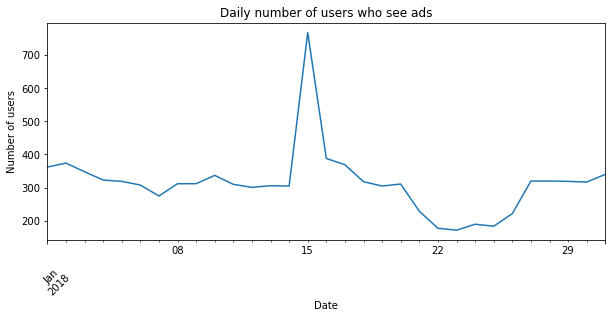

In [ ]:
# Plot conversion rate per day
daily_users.plot(figsize=(10, 4))

# Annotate
plt.title('Daily number of users who see ads')
plt.xlabel('Date')
plt.ylabel('Number of users')
plt.xticks(rotation = 45)
plt.show()


<a class="anchor" id="house-ads"></a>
### Daily Conversion Rate by Marketing Channel

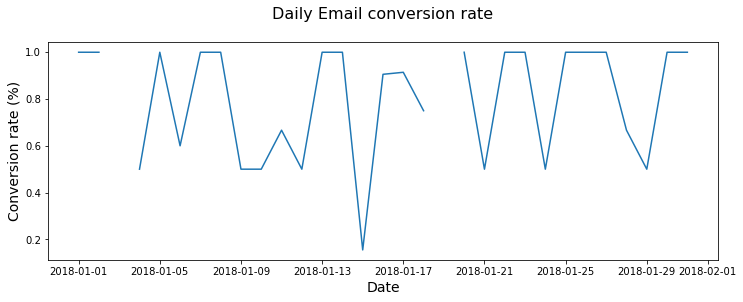

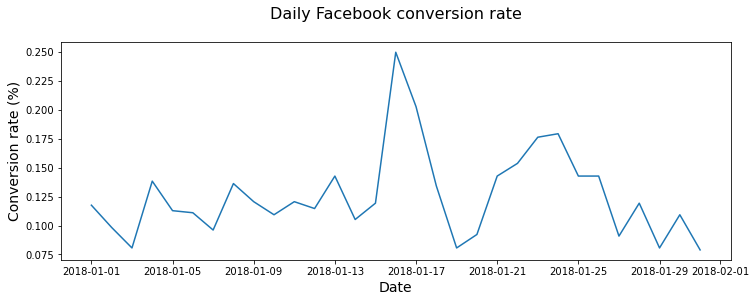

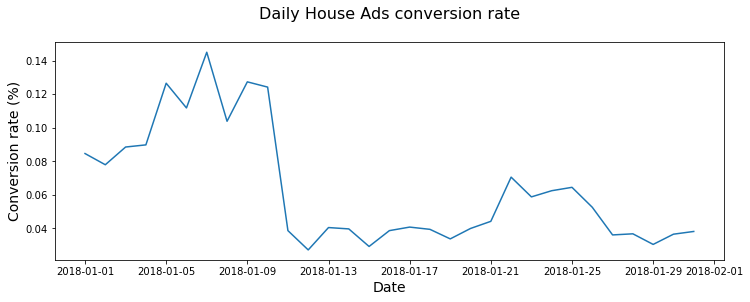

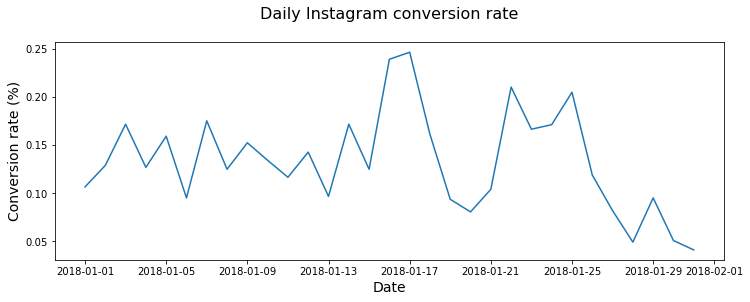

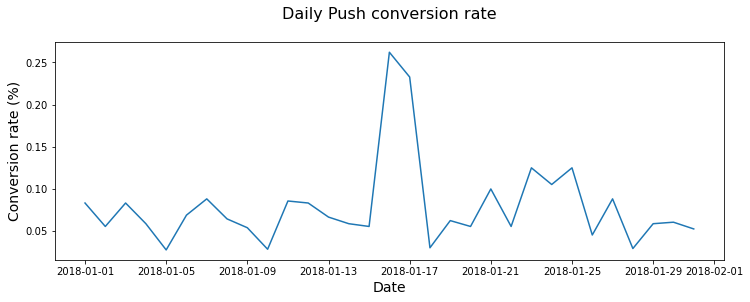

In [ ]:
# Calculate conversion rate by date served and channel
daily_conv_channel = conversion_rate(marketing, ['date_served', 
                                                 'marketing_channel'])

# Unstack daily_conv_channel and convert it to a DataFrame
daily_conv_channel = pd.DataFrame(daily_conv_channel.unstack(level = 1))

# Plot results of daily_conv_channel
plot_conversion(daily_conv_channel)

#### Language by Age Group

In [ ]:
# Create DataFrame grouped by age and language preference
language_age = marketing.groupby(['language_preferred', 'age_group'])['user_id'].count()
language_age = pd.DataFrame(language_age.unstack(level=1))
language_age.head()

age_group,0-18 years,19-24 years,24-30 years,30-36 years,36-45 years,45-55 years,55+ years
language_preferred,,,,,,,
Arabic,19,26,19,19,19,21,22
English,1421,1560,1442,1251,1260,1240,1101
German,31,29,35,16,19,25,12
Spanish,68,67,72,69,55,67,52


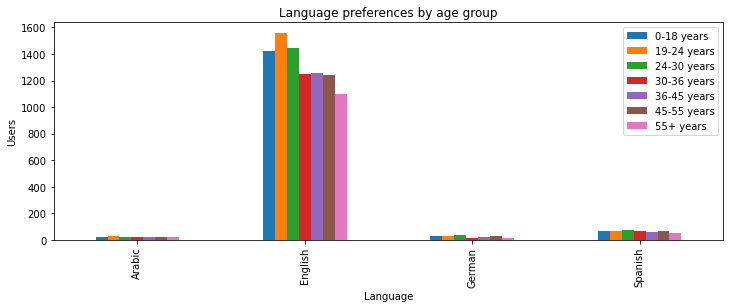

In [ ]:
language_age.plot(kind='bar', figsize=(12, 4))

plt.title('Language preferences by age group')
plt.xlabel('Language')
plt.ylabel('Users')
plt.legend(loc = 'upper right',labels = language_age.columns.values)
plt.show()


### Daily Channel  Retention Rate

In [ ]:
# Count the subs by subscribing channel and date subscribed
retention_total = marketing.groupby(['date_subscribed', 'subscribing_channel'])['user_id'].nunique()

# Print results
print(retention_total.head())

date_subscribed  subscribing_channel
2018-01-01       Email                   1
                 Facebook                8
                 House Ads              16
                 Instagram               8
                 Push                    3
Name: user_id, dtype: int64


In [ ]:
retention_rate(marketing,['date_subscribed','subscribing_channel'])

date_subscribed  subscribing_channel
2018-01-01       Email                  1.000000
                 Facebook               0.875000
                 House Ads              0.687500
                 Instagram              0.750000
                 Push                   1.000000
                                          ...   
2018-01-31       Email                  1.000000
                 Facebook               0.833333
                 House Ads              0.500000
                 Instagram              0.666667
                 Push                   0.500000
Name: user_id, Length: 155, dtype: float64

In [ ]:
retention_rate(marketing,['date_subscribed','subscribing_channel'])['2018-01-01']

subscribing_channel
Email        1.0000
Facebook     0.8750
House Ads    0.6875
Instagram    0.7500
Push         1.0000
Name: user_id, dtype: float64

In [ ]:
# Divide retained subscribers by total subscribers by marketing channel
daily_channel_retention = retention_rate(marketing,['date_subscribed','subscribing_channel'])
daily_channel_retention = pd.DataFrame(daily_channel_retention.unstack(level=1))
daily_channel_retention.head()

subscribing_channel,Email,Facebook,House Ads,Instagram,Push
date_subscribed,,,,,
2018-01-01,1.00,0.875000,0.687500,0.750000,1.000000
2018-01-02,0.75,1.000000,0.588235,0.625000,1.000000
2018-01-03,NaN,0.800000,0.647059,0.909091,0.666667
2018-01-04,1.00,0.666667,0.466667,0.500000,NaN
2018-01-05,1.00,0.571429,0.500000,0.636364,1.000000


In [ ]:
# # Plot retention rate
# daily_channel_retention.plot(figsize=(12, 5))

# # Add a title, x-label, y-label, legend and display the plot
# plt.title('Retention Rate by Subscribing Channel')
# plt.xlabel('Date Subscribed')
# plt.ylabel('Retention Rate (%)')
# plt.legend(loc = 'upper right', 
#            labels = daily_channel_retention.columns.values)
# plt.show()

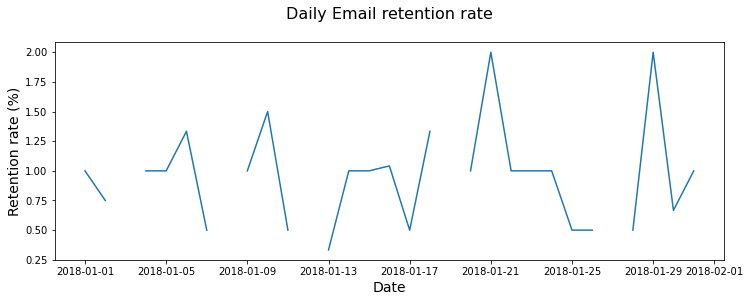

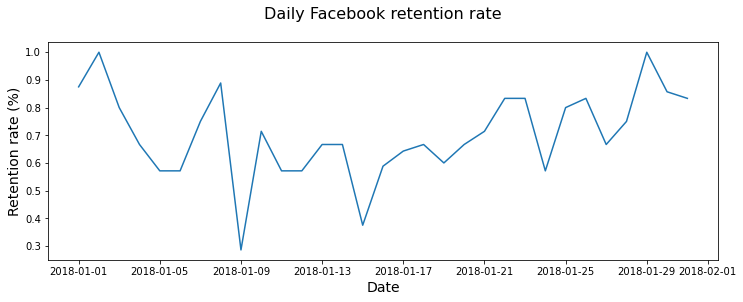

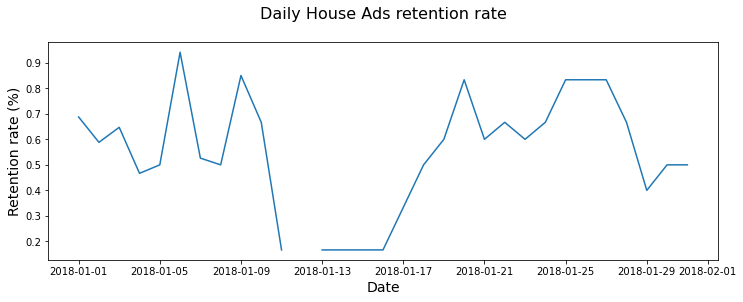

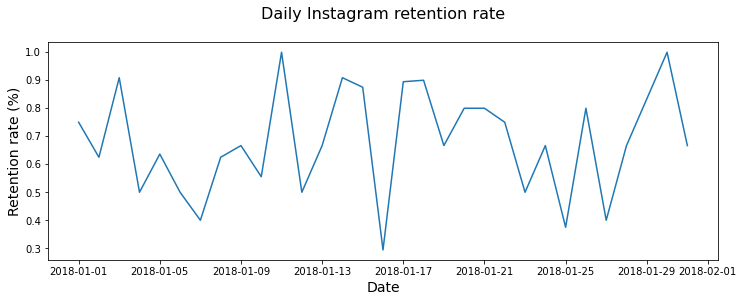

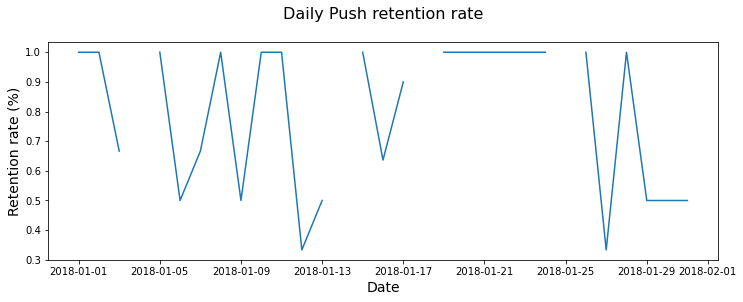

In [ ]:
plot_retention(daily_channel_retention)

In [ ]:
marketing.subscribing_channel.value_counts()

Instagram    600
Facebook     445
House Ads    354
Email        290
Push         167
Name: subscribing_channel, dtype: int64

In [ ]:
marketing.subscribing_channel.value_counts()['Instagram']

600

### Identify and Resolve Inconsistencies: Analyzing House ads conversion rate
We'll focus on the Housing Ads. If you [go back up](#house-ads), you'll notice housing ad conversin rate dropped and has been down since January 11. Why??

Now that we have confirmed that house ads conversion has been down since January 11, we will try to identify potential causes for the decrease.

As a data scientist supporting a marketing team, we will run into fluctuating metrics all the time. It's vital to identify if the fluctuations are due to expected shifts in user behavior (i.e., differences across the day of the week) versus a larger problem in technical implementation or marketing strategy.

In this exercise, we will begin by checking whether users are more likely to convert on weekends compared with weekdays and determine if that could be the cause for the changing house ads conversion rate.

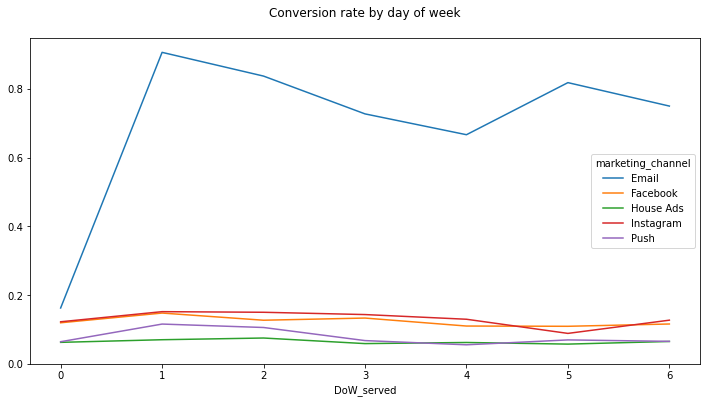

In [ ]:
# Add day of week column to marketing
marketing['DoW_served'] = marketing['date_served'].dt.dayofweek

# Calculate conversion rate by day of week
DoW_conversion = conversion_rate(marketing, ['DoW_served', 
                                             'marketing_channel'])

# Unstack channels
DoW_df = pd.DataFrame(DoW_conversion.unstack(level=1))

# Plot conversion rate by day of week
DoW_df.plot(figsize=(12, 6))
plt.title('Conversion rate by day of week\n')
plt.ylim(0)
plt.show()

### House ads conversion by language
Now that we've ruled out natural fluctuations across the day of the week a user saw our marketing assets as they cause for decreasing house ads conversion, we will take a look at `conversion by language over time`. Perhaps the new marketing campaign does not apply broadly across different cultures.

Ideally, the marketing team will consider cultural differences prior to launching a campaign, but sometimes mistakes are made, and it will be our job to identify the cause. Often data scientists are the first line of defense to determine what went wrong with a marketing campaign. It's our job to think creatively to identify the cause.

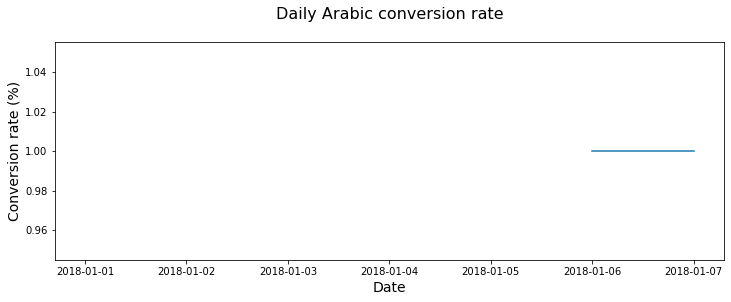

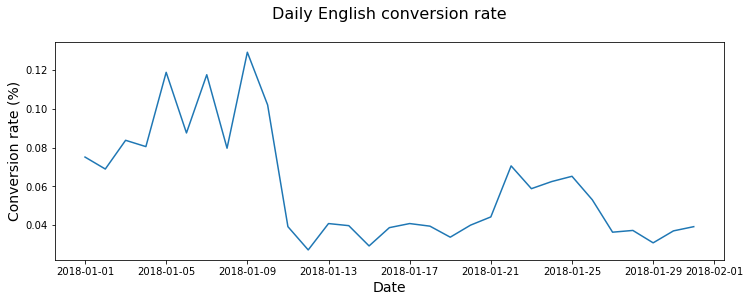

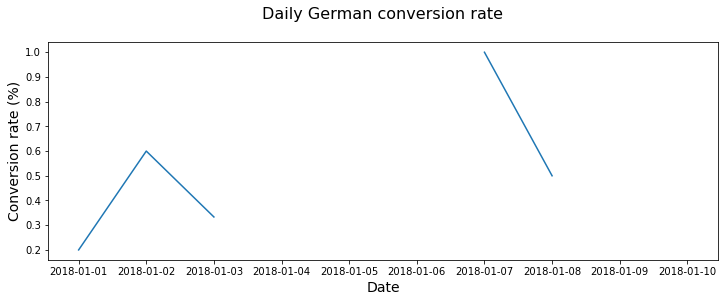

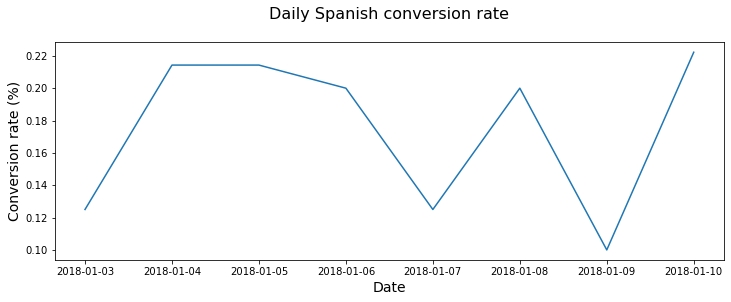

In [ ]:
# Isolate the rows where marketing channel is House Ads
house_ads = marketing[marketing['marketing_channel'] == 'House Ads']

# Calculate conversion by date served and language displayed
conv_lang_channel = conversion_rate(house_ads, 
                                    ['date_served', 
                                     'language_displayed'])

# Unstack conv_lang_channel
conv_lang_df = pd.DataFrame(conv_lang_channel.unstack(level=1))

# Use plot_retention function to display results
plot_conversion(conv_lang_df)

### Identify What the problem is specifically so that the team doesn't repeat their mistake.
- First we'll add a new column to track ads where language preferred matches displayed language

In [ ]:
# Add the new column is_correct_lang
house_ads['is_correct_lang'] = np.where(
    house_ads['language_preferred'] == house_ads['language_displayed'], 'Yes', 'No')

# Groupby date_served and is_correct_lang
language_check = house_ads.groupby(['date_served','is_correct_lang'])['is_correct_lang'].count()

# Unstack language_check and fill missing values with 0's
language_check_df = pd.DataFrame(language_check.unstack(level=1)).fillna(0)

# Print results
print(language_check_df)

is_correct_lang    No    Yes
date_served                 
2018-01-01        2.0  189.0
2018-01-02        3.0  247.0
2018-01-03        0.0  220.0
2018-01-04        0.0  168.0
2018-01-05        0.0  160.0
2018-01-06        1.0  151.0
2018-01-07        2.0  130.0
2018-01-08        0.0  154.0
2018-01-09        0.0  157.0
2018-01-10        0.0  170.0
2018-01-11       20.0  135.0
2018-01-12       18.0  130.0
2018-01-13       26.0  122.0
2018-01-14       20.0  131.0
2018-01-15       16.0  192.0
2018-01-16       28.0  127.0
2018-01-17       21.0  127.0
2018-01-18       31.0  121.0
2018-01-19       22.0  127.0
2018-01-20       28.0  124.0
2018-01-21       14.0  100.0
2018-01-22       13.0   72.0
2018-01-23       16.0   69.0
2018-01-24       13.0   83.0
2018-01-25       19.0   74.0
2018-01-26       24.0   92.0
2018-01-27       18.0  149.0
2018-01-28       28.0  136.0
2018-01-29       24.0  142.0
2018-01-30       23.0  145.0
2018-01-31       23.0  135.0


C:\Users\AADERO~1\AppData\Local\Temp/ipykernel_10444/3821003747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  house_ads['is_correct_lang'] = np.where(


#### Confirming house ads error
Now that we've created a DataFrame that checks whether users see ads in the correct language let's calculate what percentage of users were not being served ads in the right language and plot our results.

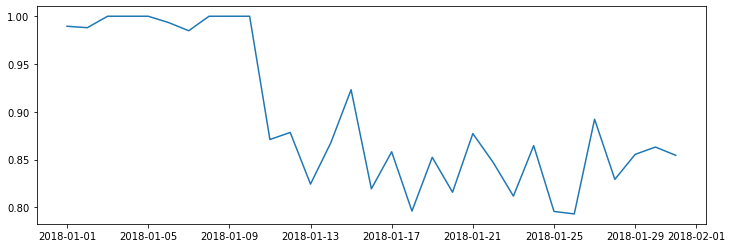

In [ ]:
# Divide the count where language is correct by the row sum
language_check_df['pct'] = language_check_df['Yes']/language_check_df.sum(axis=1)

plt.figure(figsize=(12,4))

# Plot and show your results
plt.plot(language_check_df.index.values, language_check_df['pct'])
plt.show()


### Assessing impact: Setting up conversion indexes
Now that we've determined that language is, in fact, the issue with House Ads conversion, stakeholders need to know how many subscribers they lost as a result of this bug.

Next, we will index non-English language conversion rates against English conversion rates in the `time period before the language bug arose`.

In [ ]:
# Calculate pre-error conversion rate
# Bug arose sometime around '2018-01-11'
house_ads_bug = house_ads[house_ads['date_served'] < '2018-01-11']
lang_conv = conversion_rate(house_ads_bug, ['language_displayed']) 

# Index other language conversion rate against English
spanish_index = lang_conv['Spanish']/lang_conv['English']
arabic_index = lang_conv['Arabic']/lang_conv['English']
german_index = lang_conv['German']/lang_conv['English']

print("Spanish index:", spanish_index)
print("Arabic index:", arabic_index)
print("German index:", german_index)

Spanish index: 1.681924882629108
Arabic index: 5.045774647887324
German index: 4.485133020344287


In [ ]:
lang_conv

language_displayed
Arabic     0.500000
English    0.099093
German     0.444444
Spanish    0.166667
Name: user_id, dtype: float64

### Estimating xSubscibers: Analyzing user preferences
`To understand the true impact of the bug, it is crucial to determine how many subscribers we would have expected had there been no language error`. This is crucial to understanding the scale of the problem and how important it is to prevent this kind of error in the future.

In the next step, we will `create a new DataFrame that we can perform calculations on to determine the expected number of subscribers`. This DataFrame will include how many users prefer each language by day. Once we have the DataFrame, we can begin calculating how many subscribers we would have expected to have had the language bug not occurred.

In [ ]:
# Group house_ads by date and language
converted = house_ads.groupby(['date_served', 'language_preferred']).agg({'user_id':'nunique',
                                                                          'converted':'sum'})

# Unstack converted
converted_df = pd.DataFrame(converted.unstack(level=1))

In [ ]:
converted.head()

user_id  converted
date_served language_preferred                    
2018-01-01  Arabic                    2          2
            English                 171         13
            German                    5          1
            Spanish                  11          0
2018-01-02  Arabic                    3          0

In [ ]:
converted_df.head()

user_id                        converted                 \
language_preferred  Arabic English German Spanish    Arabic English German   
date_served                                                                  
2018-01-01             2.0   171.0    5.0    11.0       2.0    13.0    1.0   
2018-01-02             3.0   200.0    5.0    10.0       0.0    14.0    3.0   
2018-01-03             2.0   179.0    3.0     8.0       0.0    15.0    1.0   
2018-01-04             2.0   149.0    2.0    14.0       0.0    12.0    0.0   
2018-01-05             NaN   143.0    1.0    14.0       NaN    17.0    0.0   

                            
language_preferred Spanish  
date_served                 
2018-01-01             0.0  
2018-01-02             0.0  
2018-01-03             1.0  
2018-01-04             3.0  
2018-01-05             3.0

In [ ]:
converted_df.loc['2018-01-11':'2018-01-31'][('converted','English')]

date_served
2018-01-11    6.0
2018-01-12    3.0
2018-01-13    5.0
2018-01-14    6.0
2018-01-15    6.0
2018-01-16    6.0
2018-01-17    2.0
2018-01-18    5.0
2018-01-19    4.0
2018-01-20    4.0
2018-01-21    5.0
2018-01-22    4.0
2018-01-23    5.0
2018-01-24    6.0
2018-01-25    4.0
2018-01-26    4.0
2018-01-27    4.0
2018-01-28    4.0
2018-01-29    3.0
2018-01-30    4.0
2018-01-31    4.0
Name: (converted, English), dtype: float64

In [ ]:
# Create English conversion rate column for affected period
converted_df['english_conv'] = converted_df.loc['2018-01-11':'2018-01-31'][('converted','English')]

# Create expected conversion rates for each language
converted_df['expected_spanish_rate'] = converted_df['english_conv']*spanish_index
converted_df['expected_arabic_rate'] = converted_df['english_conv']*arabic_index
converted_df['expected_german_rate'] = converted_df['english_conv']*german_index

# Multiply number of users by the expected conversion rate
converted_df['expected_spanish_conv'] = converted_df['expected_spanish_rate']/100*converted_df[('user_id','Spanish')]
converted_df['expected_arabic_conv'] = converted_df['expected_arabic_rate']/100*converted_df[('user_id','Arabic')]
converted_df['expected_german_conv'] = converted_df['expected_german_rate']/100*converted_df[('user_id','German')]

In [ ]:
converted_df.head()

user_id                        converted                 \
language_preferred  Arabic English German Spanish    Arabic English German   
date_served                                                                  
2018-01-01             2.0   171.0    5.0    11.0       2.0    13.0    1.0   
2018-01-02             3.0   200.0    5.0    10.0       0.0    14.0    3.0   
2018-01-03             2.0   179.0    3.0     8.0       0.0    15.0    1.0   
2018-01-04             2.0   149.0    2.0    14.0       0.0    12.0    0.0   
2018-01-05             NaN   143.0    1.0    14.0       NaN    17.0    0.0   

                           english_conv expected_spanish_rate  \
language_preferred Spanish                                      
date_served                                                     
2018-01-01             0.0          NaN                   NaN   
2018-01-02             0.0          NaN                   NaN   
2018-01-03             1.0          NaN                   NaN   
2018-01-04             3.0          NaN                   NaN   
2018-01-05             3.0          NaN                   NaN   

                   expected_arabic_rate expected_german_rate  \
language_preferred                                             
date_served                                                    
2018-01-01                          NaN                  NaN   
2018-01-02                          NaN                  NaN   
2018-01-03                          NaN                  NaN   
2018-01-04                          NaN                  NaN   
2018-01-05                          NaN                  NaN   

                   expected_spanish_conv expected_arabic_conv  \
language_preferred                                              
date_served                                                     
2018-01-01                           NaN                  NaN   
2018-01-02                           NaN                  NaN   
2018-01-03                           NaN                  NaN   
2018-01-04                           NaN                  NaN   
2018-01-05                           NaN                  NaN   

                   expected_german_conv  
language_preferred                       
date_served                              
2018-01-01                          NaN  
2018-01-02                          NaN  
2018-01-03                          NaN  
2018-01-04                          NaN  
2018-01-05                          NaN

In [ ]:
converted_df.loc['2018-01-11':'2018-01-31']

user_id                        converted                 \
language_preferred  Arabic English German Spanish    Arabic English German   
date_served                                                                  
2018-01-11             7.0   133.0    2.0    13.0       0.0     6.0    0.0   
2018-01-12             3.0   129.0    4.0    11.0       0.0     3.0    0.0   
2018-01-13             6.0   121.0    5.0    16.0       0.0     5.0    1.0   
2018-01-14             5.0   131.0    3.0    12.0       0.0     6.0    0.0   
2018-01-15             2.0   189.0    4.0    10.0       0.0     6.0    0.0   
2018-01-16             7.0   127.0    4.0    17.0       0.0     6.0    0.0   
2018-01-17             2.0   126.0    3.0    16.0       0.0     2.0    0.0   
2018-01-18             7.0   121.0    6.0    18.0       0.0     5.0    1.0   
2018-01-19             5.0   126.0    5.0    12.0       1.0     4.0    0.0   
2018-01-20             6.0   124.0    6.0    14.0       1.0     4.0    1.0   
2018-01-21             1.0    99.0    4.0     9.0       0.0     5.0    0.0   
2018-01-22             2.0    72.0    3.0     8.0       1.0     4.0    1.0   
2018-01-23             3.0    69.0    4.0     9.0       0.0     5.0    0.0   
2018-01-24             2.0    83.0    3.0     8.0       0.0     6.0    0.0   
2018-01-25             3.0    75.0    4.0    11.0       0.0     4.0    2.0   
2018-01-26             6.0    89.0    3.0    16.0       0.0     4.0    0.0   
2018-01-27             3.0   148.0    3.0    12.0       1.0     4.0    0.0   
2018-01-28             5.0   134.0    3.0    21.0       0.0     4.0    0.0   
2018-01-29             7.0   138.0    4.0    15.0       2.0     3.0    0.0   
2018-01-30             4.0   139.0    3.0    18.0       0.0     4.0    0.0   
2018-01-31             7.0   130.0    4.0    16.0       1.0     4.0    0.0   

                           english_conv expected_spanish_rate  \
language_preferred Spanish                                      
date_served                                                     
2018-01-11             0.0          6.0             10.091549   
2018-01-12             1.0          3.0              5.045775   
2018-01-13             0.0          5.0              8.409624   
2018-01-14             0.0          6.0             10.091549   
2018-01-15             0.0          6.0             10.091549   
2018-01-16             0.0          6.0             10.091549   
2018-01-17             4.0          2.0              3.363850   
2018-01-18             0.0          5.0              8.409624   
2018-01-19             0.0          4.0              6.727700   
2018-01-20             0.0          4.0              6.727700   
2018-01-21             0.0          5.0              8.409624   
2018-01-22             0.0          4.0              6.727700   
2018-01-23             0.0          5.0              8.409624   
2018-01-24             0.0          6.0             10.091549   
2018-01-25             0.0          4.0              6.727700   
2018-01-26             2.0          4.0              6.727700   
2018-01-27             1.0          4.0              6.727700   
2018-01-28             2.0          4.0              6.727700   
2018-01-29             0.0          3.0              5.045775   
2018-01-30             2.0          4.0              6.727700   
2018-01-31             1.0          4.0              6.727700   

                   expected_arabic_rate expected_german_rate  \
language_preferred                                             
date_served                                                    
2018-01-11                    30.274648            26.910798   
2018-01-12                    15.137324            13.455399   
2018-01-13                    25.228873            22.425665   
2018-01-14                    30.274648            26.910798   
2018-01-15                    30.274648            26.910798   
2018-01-16                    30.274648            26.910798   
2018-01-1

### Assessing bug impact
It's time to calculate how many subscribers were lost due to mistakenly serving users English rather than their preferred language. Once the team has an estimate of the impact of this error, they can determine whether it's worth putting additional checks in place to avoid this in the future—you might be thinking, of course, it's worth it to try to prevent errors! In a way, you're right, but every choice a company makes requires work and funding. The more information your team has, the better they will be able to evaluate this trade-off.

In [ ]:
# Use .loc to slice only the relevant dates
converted_df = converted_df.loc['2018-01-11':'2018-01-31']

# Sum expected subscribers for each language in `converted_df`
expected_subs = converted_df['expected_spanish_conv'].sum() + converted_df['expected_arabic_conv'].sum() + converted_df['expected_german_conv'].sum()
# converted_df[['expected_spanish_conv', 'expected_arabic_conv', 'expected_german_conv']].sum().sum()

# Calculate how many subscribers we actually got
actual_subs = converted_df[('converted','Spanish')].sum() + converted_df[('converted','Arabic')].sum() + converted_df[('converted','German')].sum()

# Subtract how many subscribers we got despite the bug
lost_subs = expected_subs - actual_subs
print(lost_subs)

32.14414319248826


### A/B Testing
Here, we will take a high-level look into how A/B tests are conducted in marketing departments.

#### But first, What is A/B testing?
`A/B testing refers to a randomized experiment which evaluates which variant performs better`. In order for our tests to have meaning, we must have a clear `control`. The control should be something that currently exists and is running in production. Each variant in the test should have only one major change from the control; otherwise, it will be impossible to parse what led to the change in your key metrics. \
Prior to beginning a test, you must develop a hypothesis and determine which metric you are trying to impact. Always set key metrics ahead of running the test. It's easy to redefine success in retrospect, especially if you are under pressure to find a positive result. If you document success metrics ahead of time, you can maintain clarity around the success of the test.

>Testing allows us to understand marketing impact. A big benefit of running A/B tests is we can be confident that the increase in the relevant metrics was due to the action we took in the test.


#### Personalized email test
The focus of this chapter will be the A/B test that was run where half the emails were generic upsells to our product while the other half contained personalized messaging around individual usage of our site.

### Test allocation
The email portion of this campaign was actually run as an A/B test. Half the emails sent out were generic upsells to your product while the other half contained personalized messaging around the users’ usage of the site.

Before you begin analyzing the results, you will check to ensure users were allocated equally to the test and control groups.

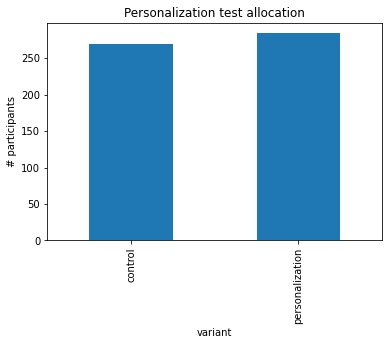

In [ ]:
# Subset the DataFrame
email = marketing[marketing['marketing_channel'] == 'Email']

# Group the email DataFrame by variant 
alloc = email.groupby(['variant'])['user_id'].nunique()

# Plot a bar chart of the test allocation
alloc.plot(kind='bar')
plt.title('Personalization test allocation')
plt.ylabel('# participants')
plt.show()

>Allocation is relatively even, but not exactly the same. This will typically be the case. If allocation had gone wrong, there are statistical tests to determine the likelihood that the difference in allocation is due to random chance, but we will not explore that yet. In this case, we can proceed with the assumption that there were no issues in the randomization process.

### Comparing conversion rates
Now that we know allocation is relatively even let's look at the conversion rate for the control and personalization. `Since we chose conversion rate as our key metrics for this test, it is highly important that we evaluate whether or not conversion was higher in the personalization treatment compared with the control`. While we will dive in deeper in subsequent exercises, measuring the difference between the key metric in the control and the treatment is the most important part of evaluating the success of an A/B test.

In [ ]:
# Group marketing by user_id and variant
# First, we ensure each user and variant has only one subscription outcome by using the groupby() and max() methods.
#  We use the max() method on the 'converted' column since it's a boolean, and if there are multiple rows 
# with False and True values, we want to consider the row where the user was converted, that is, True
subscribers = email.groupby(['user_id', 
                             'variant'])['converted'].max()
subscribers_df = pd.DataFrame(subscribers.unstack(level=1)) 


# Drop missing values from the control column
control = subscribers_df['control'].dropna()

# Drop missing values from the personalization column
personalization = subscribers_df['personalization'].dropna()

print('Control conversion rate:', np.mean(control))
print('Personalization conversion rate:', np.mean(personalization))

Control conversion rate: 0.2814814814814815
Personalization conversion rate: 0.3908450704225352


>**Is this difference significant?**

Let's get testing!

### Calculating Lift & Significance testing
The first question you'll want to answer when running a test is, "What's the Lift?". In this case, what this means is, "Was the conversion rate higher for the treatment and by how much?". 

Lift is calculated by taking the difference between the treatment conversion rate and the control conversion rate divided by the control conversion rate. The result is the relative percent difference of treatment compared to control.

In [ ]:
# create Lift function
def lift(a,b):
    # Calcuate the mean of a and b 
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    
    # Calculate the lift using a_mean and b_mean
    lift = (b_mean-a_mean)/a_mean
  
    return f"Lift: {str(round(lift*100, 2))}%"
  
# Print lift() with control and personalization as inputs
print(lift(control, personalization))

Lift: 38.85%


>As you can see, the personalization variant improved on the control conversion rate by 35%. That's some improvement and a good signal that we should consider running personalized emails again in the future. But before we get ahead of ourselves, let's talk *statistical significance*.

In [ ]:
from scipy.stats import ttest_ind

t = ttest_ind(control, personalization)

print(t)

Ttest_indResult(statistic=-2.7343299447505074, pvalue=0.006451487844694175)


> Amazing job! With a p-value less than 0.5, The personalization results are highly statistically significant, at confidence level of 95%

Next, let's explore whether that holds up across all demographics.

### A/B testing & segmentation
One of the most common pitfalls in A/B testing is assuming that a treatment equally affects everyone in a population.

Just like with any other kind of marketing, some treatments are particularly effective on users of a specific engagement level, age, race, or any other of a number of factors. Often a treatment will not affect all people uniformly. Some people will love a particular marketing campaign while others hate it.

It is important to break down results by various demographics in order to obtain a holistic understanding of the impact of the test. Not all customers are alike!

In [ ]:
def ab_segmentation(segment):
  # Build a for loop for each segment in marketing
  for subsegment in np.unique(marketing[segment].values):
        print(subsegment)
      
        # Limit marketing to email and subsegment      
        email = marketing[(marketing['marketing_channel'] == 'Email') & (marketing[segment] == subsegment)]
        
        # isolate subscribers
        subscribers = email.groupby(['user_id', 'variant'])['converted'].max()
        subscribers = pd.DataFrame(subscribers.unstack(level=1)) 
        
        # isolate control and personalization
        control = subscribers['control'].dropna()
        personalization = subscribers['personalization'].dropna()
        
        print('lift:', lift(control, personalization))
        print('t-statistic:', ttest_ind(control, personalization), '\n\n')

#### A/B segmentation on Language Displayed

In [ ]:
# Use ab_segmentation on language displayed
ab_segmentation('language_displayed')

Arabic
lift: Lift: 50.0%
t-statistic: Ttest_indResult(statistic=-0.5773502691896255, pvalue=0.5795840000000001) 


English
lift: Lift: 39.0%
t-statistic: Ttest_indResult(statistic=-2.2183598646203166, pvalue=0.026991701290720815) 


German
lift: Lift: -1.62%
t-statistic: Ttest_indResult(statistic=0.1910083418078718, pvalue=0.8494394170062678) 


Spanish
lift: Lift: 166.67%
t-statistic: Ttest_indResult(statistic=-2.3570226039551585, pvalue=0.040156718110477524) 




>We found that personalization was really effective for all languages but German.

Perhaps, Germans don't appreciate personalizations.

#### A/B segmentation on Age Group

In [ ]:
# Use ab_segmentation on age group
ab_segmentation('age_group')

0-18 years
lift: Lift: 121.4%
t-statistic: Ttest_indResult(statistic=-2.966044912142211, pvalue=0.0038724494391297226) 


19-24 years
lift: Lift: 106.24%
t-statistic: Ttest_indResult(statistic=-3.03179438478667, pvalue=0.0030623836114689134) 


24-30 years
lift: Lift: 161.19%
t-statistic: Ttest_indResult(statistic=-3.861539544326876, pvalue=0.00018743381094867337) 


30-36 years
lift: Lift: -100.0%
t-statistic: Ttest_indResult(statistic=3.1859064644147996, pvalue=0.0023238487431765137) 


36-45 years
lift: Lift: -85.23%
t-statistic: Ttest_indResult(statistic=2.4317901279318503, pvalue=0.01797568600978829) 


45-55 years
lift: Lift: -72.22%
t-statistic: Ttest_indResult(statistic=2.065499127317933, pvalue=0.043062339688201196) 


55+ years
lift: Lift: -100.0%
t-statistic: Ttest_indResult(statistic=3.3265654564203397, pvalue=0.0016358623456360435) 




>Coool. We found that personalization was `extremely effective for younger groups but less effective than the control for older groups`. 

One explanation might be that `younger users understand how their data might be used online and think personalization is cool` because it gives them more insight into themselves while `older people might feel that this is a violation of their privacy`.

<!-- [Analyzing Marketing Campaign with Pandas](https://campus.datacamp.com/courses/analyzing-marketing-campaigns-with-pandas/personalization-ab-test?ex=11) -->